In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
from datetime import datetime

In [2]:
Rdrive = '/exports/csce/datastore/geos/users/s1332488/'
logging_pts = gpd.read_file(Rdrive+'logging_jan20_points.shp')
ctrl_pts = gpd.read_file(Rdrive+'control_jan20_points.shp')

In [19]:
ds = xr.open_dataset('/disk/scratch/local.4/harry/S1/NC/Gabon_Coh.nc')
ds = ds / ds.median(dim=['lat','lon']) # remove whole image variation
ds = ds.rolling(t=5,lat=3,lon=3,center=True).mean() # smoothing
texture = ds.rolling(t=5,lat=3,lon=3,center=True).std() # Get Texture

/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [30]:
# Select reference period and change detection period

ref = slice(None,'2019-12-31')
change =slice('2019-12-01',None)

ref_ds = ds.sel(t=ref)
change_ds = ds.sel(t=change)

# Get mean and std of coherence in reference period
ref_mean = ref_ds.mean(dim='t')
ref_std = ref_ds.std(dim='t')
ref_texture = texture.sel(t=ref)

# Normalise change detection period
change_ds = (change_ds - ref_mean) / ref_std
texture_ds = (texture.sel(t=change) - ref_texture.mean(dim='t')) / ref_texture.std(dim='t')


/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/exports/csce/datastore/geos/u

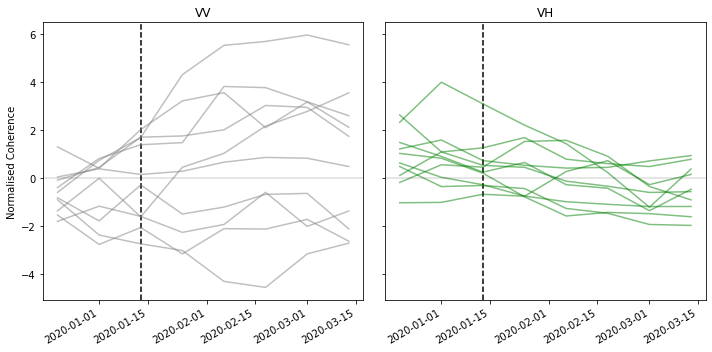

In [18]:
## Plot to see if pixels with known logging date show a discernible signal by eye

fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)
with change_ds.drop('crs').rio.write_crs('EPSG:4326') as ds:
    for i in range(len(logging_pts)):
        point = ds.sel(lat=logging_pts.geometry[i].y,
                       lon=logging_pts.geometry[i].x,
                       method='nearest')
        point.coh_VV.isel(t=slice(None,8)).plot(color='grey',ax=axs[0],alpha=.5)
        point.coh_VH.isel(t=slice(None,8)).plot(color='green',ax=axs[1],alpha=.5)
#     for i in range(len(ctrl_pts)):
#         point = ds.sel(lat=ctrl_pts.geometry[i].y,
#                        lon=ctrl_pts.geometry[i].x,
#                        method='nearest')
#         point.coh_VV.isel(t=slice(None,8)).plot(color='grey',ax=axs[1,0],alpha=.5)
#         (point.coh_VH.isel(t=slice(None,8))-point.coh_VV.isel(t=slice(None,8))).plot(color='green',ax=axs[1,1],alpha=.5)
axs[0].axvline(x=datetime(2020,1,13),zorder=1,color='black',ls='--')
axs[1].axvline(x=datetime(2020,1,13),zorder=1,color='black',ls='--')
axs[0].axhline(y=0,color='black',lw=0.2)
axs[1].axhline(y=0,color='black',lw=0.2)
axs[0].set(title='VV',xlabel=None,ylabel='Normalised Coherence')
axs[1].set(title='VH',xlabel=None,ylabel=None)
plt.tight_layout()

plt.savefig('/home/s1332488/chapter2/logged_points_coh.png',dpi=300)



In [31]:
uav = xr.open_rasterio('/exports/csce/datastore/geos/users/s1332488/UAV_gab_divided_30.tif')
# This is canopy height drop divided by -30 (i.e. 0 is no change, and 1 is loss of 30 m)
uav = uav.where(uav>-1).where(uav<10)
ones = uav > 1
zeroes = uav < 0
uav_clip = uav.where(~ones,other=1)
uav_clip = uav_clip.where(~zeroes,other=0) # Clip so no values less than zero or greater than 1
uav_clip = uav_clip.rename({'y':'lat','x':'lon'})

# Merge with S-1 Data
M = xr.merge([change_ds,
              texture_ds.rename({'coh_VV':'texture_VV','coh_VH':'texture_VH'}),
              uav_clip.to_dataset(name='uav').interp_like(change_ds)],
            compat='override')

M

/home/s1332488/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  """Entry point for launching an IPython kernel.


<xarray.Dataset>
Dimensions:     (t: 35, lat: 260, lon: 480, band: 1)
Coordinates:
  * t           (t) datetime64[ns] 2019-12-20 2020-01-01 ... 2021-01-31
  * lat         (lat) float64 -0.1279 -0.128 -0.1281 ... -0.1603 -0.1604 -0.1605
  * lon         (lon) float64 12.24 12.24 12.24 12.24 ... 12.3 12.3 12.3 12.3
  * band        (band) int64 1
Data variables:
    crs         float64 nan
    coh_VV      (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    coh_VH      (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    theta       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    texture_VV  (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    texture_VH  (t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    uav         (band, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [34]:
# Finally, save as "training data"
training = M.where(M.uav>-1)
training.squeeze().drop('band').to_netcdf('/disk/scratch/local.4/harry/S1/Gabon_training_data.nc')